# 🤖 ML Return Prediction - SIMPLIFIED & WORKING

## Notebook 03: Stock Return Forecasting with Machine Learning

**Goal**: Predict future stock returns (1M and 3M) using historical data

**Data Available**:
- 503 S&P 500 stocks
- 250 days of price history
- 28 technical indicators (pre-calculated in database)

**Approach**:
- Use existing technical indicators (no complex feature engineering)
- Train XGBoost models
- Predict 1M and 3M returns
- Rank all 503 stocks → Select top 50

**Last Updated**: 2025-10-03

---


## 📚 Step 1: Import Libraries


In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime

# ML
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Database
from dotenv import load_dotenv
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
load_dotenv(project_root / '.env')
from utils.database_connector import DatabaseConnector

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("✅ Libraries loaded")


✅ Libraries loaded


## ⚙️ Step 2: Configuration


In [2]:
CONFIG = {
    'HORIZONS': {
        '1M': 20,   # 20 trading days
        '3M': 60,   # 60 trading days
    },
    'RANDOM_STATE': 42,
    'TEST_SIZE': 0.2,
    'TOP_N': 50,
}

print("📊 Configuration:")
print(f"   Horizons: {list(CONFIG['HORIZONS'].keys())}")
print(f"   Test size: {CONFIG['TEST_SIZE']*100:.0f}%")
print(f"   Top stocks: {CONFIG['TOP_N']}")


📊 Configuration:
   Horizons: ['1M', '3M']
   Test size: 20%
   Top stocks: 50


## 📊 Step 3: Load Data from Database


### 3.1 Connect to Database


In [3]:
db = DatabaseConnector()
if db.test_connection():
    print("✅ Connected to database")
else:
    raise Exception("❌ Connection failed")


2025-10-03 15:59:34,293 - INFO - Attempting connection with pymssql...
2025-10-03 15:59:34,321 - INFO - ✅ Database connection established
2025-10-03 15:59:34,430 - INFO - ✅ Database connection test passed


✅ Connected to database


### 3.2 Load Price Data + Technical Indicators (Combined)


In [4]:
# Load ALL data in ONE query - prices + technical indicators
query = """
SELECT 
    p.ticker,
    p.date,
    p.[close] as price,
    p.volume,
    t.sma_20,
    t.sma_50,
    t.sma_200,
    t.rsi_14,
    t.macd,
    t.macd_signal,
    t.adx_14,
    t.atr_14,
    t.volatility_20,
    CASE WHEN t.trend_signal = 'bullish' THEN 1 ELSE 0 END as trend_bullish
FROM market.daily_prices p
LEFT JOIN market.technical_indicators t 
    ON p.ticker = t.ticker AND p.date = t.date
WHERE p.ticker IN (SELECT ticker FROM market.sp500_tickers)
  AND p.date >= '2024-11-01'
ORDER BY p.ticker, p.date
"""

print("🔄 Loading data...")
df = pd.read_sql(query, db.engine)
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Loaded: {len(df):,} rows, {df['ticker'].nunique()} stocks")
print(f"   Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"   Columns: {df.columns.tolist()}")
display(df.head())


🔄 Loading data...
✅ Loaded: 114,684 rows, 503 stocks
   Date range: 2024-11-01 → 2025-10-01
   Columns: ['ticker', 'date', 'price', 'volume', 'sma_20', 'sma_50', 'sma_200', 'rsi_14', 'macd', 'macd_signal', 'adx_14', 'atr_14', 'volatility_20', 'trend_bullish']


,ticker,date,price,volume,sma_20,sma_50,sma_200,rsi_14,macd,macd_signal,adx_14,atr_14,volatility_20,trend_bullish
0,A,2024-11-01,135.7687,2077700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,A,2024-11-04,138.5264,1795400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,A,2024-11-05,139.2802,1240500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,A,2024-11-06,136.6714,2528900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,A,2024-11-07,138.5065,2182800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## 🎯 Step 4: Calculate Target Variables (Future Returns)


In [5]:
# Calculate forward returns for each stock
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

for name, days in CONFIG['HORIZONS'].items():
    # Shift prices backward to get future price
    df[f'future_price_{name}'] = df.groupby('ticker')['price'].shift(-days)
    # Calculate return
    df[f'return_{name}'] = (df[f'future_price_{name}'] - df['price']) / df['price']
    df = df.drop(columns=[f'future_price_{name}'])

# Count valid vs NaN
for horizon in CONFIG['HORIZONS'].keys():
    col = f'return_{horizon}'
    valid = df[col].notna().sum()
    print(f"   {horizon}: {valid:,} valid samples ({valid/len(df)*100:.1f}%)")

display(df[['ticker', 'date', 'price', 'return_1M', 'return_3M']].tail(10))


   1M: 104,624 valid samples (91.2%)
   3M: 84,504 valid samples (73.7%)


,ticker,date,price,return_1M,return_3M
114674,ZTS,2025-09-18,147.10,NaN,NaN
114675,ZTS,2025-09-19,145.88,NaN,NaN
114676,ZTS,2025-09-22,144.65,NaN,NaN
114677,ZTS,2025-09-23,142.61,NaN,NaN
114678,ZTS,2025-09-24,141.67,NaN,NaN
114679,ZTS,2025-09-25,141.13,NaN,NaN
114680,ZTS,2025-09-26,143.50,NaN,NaN
114681,ZTS,2025-09-29,143.06,NaN,NaN
114682,ZTS,2025-09-30,146.32,NaN,NaN
114683,ZTS,2025-10-01,146.95,NaN,NaN


## 🧹 Step 5: Data Cleaning


In [6]:
# Remove rows where we don't have FUTURE returns (can't train on those)
print(f"Before filtering: {len(df):,} rows")

df_clean = df[df['return_3M'].notna()].copy()  # Keep rows with valid 3M returns

print(f"After filtering: {len(df_clean):,} rows")
print(f"Removed: {len(df) - len(df_clean):,} rows (last 60 days with no future data)")

# Fill NaN in FEATURES (not targets!) with median
feature_cols = ['sma_20', 'sma_50', 'sma_200', 'rsi_14', 'macd', 'macd_signal', 
                'adx_14', 'atr_14', 'volatility_20', 'trend_bullish']

print("\n🔧 Handling NaN in features:")
for col in feature_cols:
    nan_count = df_clean[col].isna().sum()
    if nan_count > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        print(f"   {col}: Filled {nan_count:,} NaN with median")

print(f"\n✅ Clean dataset: {len(df_clean):,} rows ready for ML")
print(f"   Stocks: {df_clean['ticker'].nunique()}")
print(f"   Date range: {df_clean['date'].min().date()} → {df_clean['date'].max().date()}")


Before filtering: 114,684 rows
After filtering: 84,504 rows
Removed: 30,180 rows (last 60 days with no future data)

🔧 Handling NaN in features:
   sma_20: Filled 84,504 NaN with median
   sma_50: Filled 84,504 NaN with median
   sma_200: Filled 84,504 NaN with median
   rsi_14: Filled 84,504 NaN with median
   macd: Filled 84,504 NaN with median
   macd_signal: Filled 84,504 NaN with median
   adx_14: Filled 84,504 NaN with median
   atr_14: Filled 84,504 NaN with median
   volatility_20: Filled 84,504 NaN with median

✅ Clean dataset: 84,504 rows ready for ML
   Stocks: 503
   Date range: 2024-11-01 → 2025-07-08


## 🔧 Step 6: Prepare Data for Machine Learning


In [7]:
# Define features (X) and targets (y)
feature_columns = ['price', 'volume', 'sma_20', 'sma_50', 'sma_200', 'rsi_14', 
                   'macd', 'macd_signal', 'adx_14', 'atr_14', 'volatility_20', 'trend_bullish']

print("📊 Features (X):")
for col in feature_columns:
    print(f"   - {col}")

print(f"\n🎯 Targets (y): return_1M, return_3M")

# Extract features
X = df_clean[feature_columns].copy()
print(f"\n✅ X shape: {X.shape} ({X.shape[0]:,} samples × {X.shape[1]} features)")

# Check for any remaining NaN
if X.isna().sum().sum() > 0:
    print("⚠️  Warning: Still have NaN in features")
    print(X.isna().sum())
else:
    print("✅ No NaN in features")


📊 Features (X):
   - price
   - volume
   - sma_20
   - sma_50
   - sma_200
   - rsi_14
   - macd
   - macd_signal
   - adx_14
   - atr_14
   - volatility_20
   - trend_bullish

🎯 Targets (y): return_1M, return_3M

✅ X shape: (84504, 12) (84,504 samples × 12 features)
⚠️  Warning: Still have NaN in features
price                0
volume               0
sma_20           84504
sma_50           84504
sma_200          84504
rsi_14           84504
macd             84504
macd_signal      84504
adx_14           84504
atr_14           84504
volatility_20    84504
trend_bullish        0
dtype: int64


## 📅 Step 7: Train-Test Split (Time-Series Aware)


In [8]:
# Sort by date and split chronologically
df_clean = df_clean.sort_values('date').reset_index(drop=True)

# Calculate split index
split_idx = int(len(df_clean) * (1 - CONFIG['TEST_SIZE']))
split_date = df_clean['date'].iloc[split_idx]

train_df = df_clean.iloc[:split_idx].copy()
test_df = df_clean.iloc[split_idx:].copy()

print(f"📊 Train-Test Split:")
print(f"   Split date: {split_date.date()}")
print(f"   Train: {len(train_df):,} samples ({train_df['date'].min().date()} → {train_df['date'].max().date()})")
print(f"   Test:  {len(test_df):,} samples ({test_df['date'].min().date()} → {test_df['date'].max().date()})")

# Prepare X and y for both horizons
X_train = train_df[feature_columns]
X_test = test_df[feature_columns]

print(f"\n✅ Ready for training:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")


📊 Train-Test Split:
   Split date: 2025-05-19
   Train: 67,603 samples (2024-11-01 → 2025-05-19)
   Test:  16,901 samples (2025-05-19 → 2025-07-08)

✅ Ready for training:
   X_train: (67603, 12)
   X_test: (16901, 12)


## 📏 Step 8: Feature Scaling


In [9]:
# Scale features (helps model convergence)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using RobustScaler")
print(f"   Train: {X_train_scaled.shape}")
print(f"   Test: {X_test_scaled.shape}")


✅ Features scaled using RobustScaler
   Train: (67603, 12)
   Test: (16901, 12)


## 🤖 Step 9: Train XGBoost Models


In [10]:
models = {}
predictions = {}
metrics = {}

for horizon in CONFIG['HORIZONS'].keys():
    print(f"\n{'='*60}")
    print(f"Training: {horizon} Prediction Model")
    print(f"{'='*60}")
    
    # Get target for this horizon
    y_train = train_df[f'return_{horizon}']
    y_test = test_df[f'return_{horizon}']
    
    print(f"   Target: return_{horizon}")
    print(f"   y_train: {y_train.shape}, Mean={y_train.mean()*100:.2f}%")
    print(f"   y_test: {y_test.shape}, Mean={y_test.mean()*100:.2f}%")
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=CONFIG['RANDOM_STATE'],
        n_jobs=-1
    )
    
    print(f"\n   🔄 Training...")
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    dir_acc = np.mean((y_test > 0) == (y_pred_test > 0))
    
    print(f"   ✅ Training complete!")
    print(f"      Train RMSE: {train_rmse:.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test R²: {test_r2:.3f}")
    print(f"      Directional Accuracy: {dir_acc:.1%}")
    
    # Store results
    models[horizon] = model
    predictions[horizon] = y_pred_test
    metrics[horizon] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'directional_accuracy': dir_acc
    }

print(f"\n{'='*60}")
print("✅ ALL MODELS TRAINED!")
print(f"{'='*60}")



Training: 1M Prediction Model
   Target: return_1M
   y_train: (67603,), Mean=-0.01%
   y_test: (16901,), Mean=2.76%

   🔄 Training...
   ✅ Training complete!
      Train RMSE: 0.0945
      Test RMSE: 0.0865
      Test R²: -0.145
      Directional Accuracy: 49.8%

Training: 3M Prediction Model
   Target: return_3M
   y_train: (67603,), Mean=1.30%
   y_test: (16901,), Mean=5.92%

   🔄 Training...
   ✅ Training complete!
      Train RMSE: 0.1571
      Test RMSE: 0.1559
      Test R²: -0.092
      Directional Accuracy: 58.0%

✅ ALL MODELS TRAINED!


## 📊 Step 10: Model Evaluation


📊 Model Performance Summary:


,Horizon,train_rmse,test_rmse,test_r2,directional_accuracy
0,1M,0.0945,0.0865,-0.1445,0.4982
1,3M,0.1571,0.1559,-0.0923,0.5800


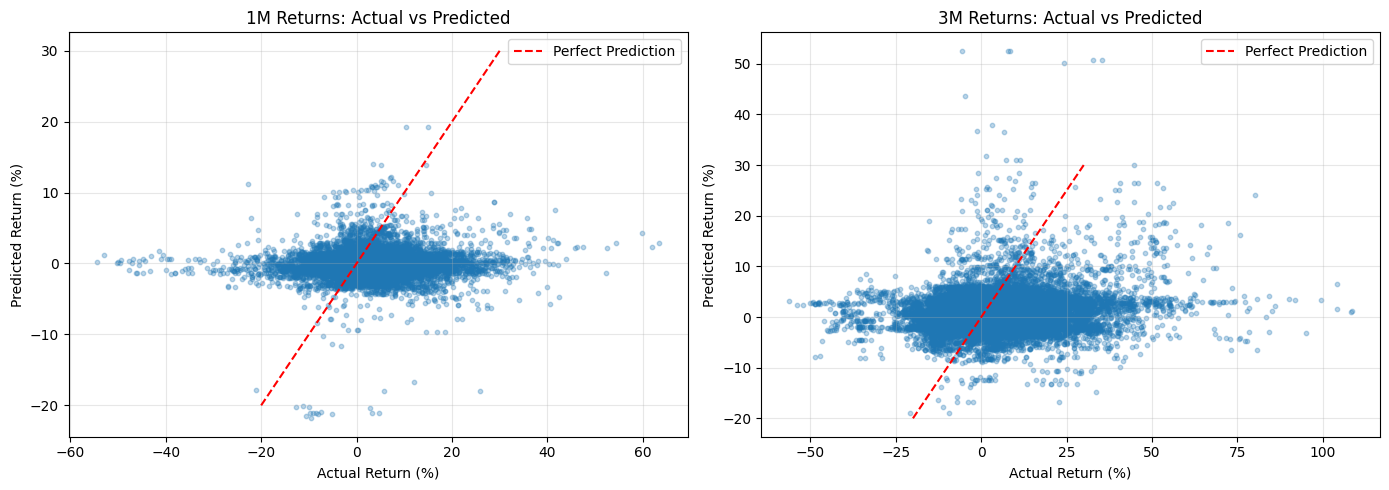

In [11]:
# Create metrics summary
metrics_df = pd.DataFrame(metrics).T
metrics_df.index.name = 'Horizon'
metrics_df = metrics_df.reset_index()

print("📊 Model Performance Summary:")
display(metrics_df.round(4))

# Visualize: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, horizon in enumerate(CONFIG['HORIZONS'].keys()):
    ax = axes[idx]
    
    y_true = test_df[f'return_{horizon}'].values
    y_pred = predictions[horizon]
    
    ax.scatter(y_true * 100, y_pred * 100, alpha=0.3, s=10)
    ax.plot([-20, 30], [-20, 30], 'r--', label='Perfect Prediction')
    ax.set_xlabel('Actual Return (%)')
    ax.set_ylabel('Predicted Return (%)')
    ax.set_title(f'{horizon} Returns: Actual vs Predicted')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🔮 Step 11: Generate Predictions for All Stocks


In [12]:
# Use LATEST data for each stock to make predictions
latest_df = df_clean.groupby('ticker').tail(1).reset_index(drop=True)

print(f"🔄 Generating predictions for {len(latest_df)} stocks...")

X_latest = latest_df[feature_columns]
X_latest_scaled = scaler.transform(X_latest)

# Predict for each horizon
results = latest_df[['ticker', 'date', 'price']].copy()

for horizon in CONFIG['HORIZONS'].keys():
    model = models[horizon]
    results[f'pred_return_{horizon}'] = model.predict(X_latest_scaled)

# Load company info
company_info = pd.read_sql("SELECT ticker, company_name, sector FROM market.sp500_tickers", db.engine)
results = results.merge(company_info, on='ticker', how='left')

print(f"✅ Predictions generated for {len(results)} stocks")
print(f"\n📊 Prediction Statistics:")
for horizon in CONFIG['HORIZONS'].keys():
    col = f'pred_return_{horizon}'
    print(f"   {horizon}: Mean={results[col].mean()*100:.2f}%, Std={results[col].std()*100:.2f}%")

display(results.head())


🔄 Generating predictions for 503 stocks...
✅ Predictions generated for 503 stocks

📊 Prediction Statistics:
   1M: Mean=-0.17%, Std=1.95%
   3M: Mean=0.98%, Std=3.71%


,ticker,date,price,pred_return_1M,pred_return_3M,company_name,sector
0,MPWR,2025-07-08,759.9705,-0.025337,-0.029620,Monolithic Power Systems,Information Technology
1,UNP,2025-07-08,235.0719,0.001971,0.025197,Union Pacific Corporation,Industrials
2,AME,2025-07-08,181.0340,-0.008370,-0.020354,Ametek,Industrials
3,FDS,2025-07-08,443.2686,-0.008603,-0.044879,FactSet,Financials
4,APO,2025-07-08,144.4794,-0.001949,0.007602,Apollo Global Management,Financials


## 🏆 Step 12: Rank Stocks & Select Top 50


In [13]:
# Rank by 3M predicted return (primary criterion)
results['rank'] = results['pred_return_3M'].rank(ascending=False)
results = results.sort_values('rank')

# Select top N
top_stocks = results.head(CONFIG['TOP_N'])

print("=" * 80)
print(f"🏆 TOP {CONFIG['TOP_N']} STOCKS BY ML PREDICTIONS")
print("=" * 80)
print(f"\nSector Distribution:")
print(top_stocks['sector'].value_counts())

print(f"\n📈 Top {CONFIG['TOP_N']} Statistics:")
print(f"   Avg Predicted 1M Return: {top_stocks['pred_return_1M'].mean()*100:.2f}%")
print(f"   Avg Predicted 3M Return: {top_stocks['pred_return_3M'].mean()*100:.2f}%")

print(f"\n🎯 Top 10 Picks:")
display(top_stocks[['rank', 'ticker', 'company_name', 'sector', 'pred_return_1M', 'pred_return_3M']].head(10))


🏆 TOP 50 STOCKS BY ML PREDICTIONS

Sector Distribution:
sector
Financials                10
Information Technology     8
Communication Services     8
Consumer Staples           6
Consumer Discretionary     4
Industrials                4
Materials                  3
Health Care                3
Utilities                  2
Energy                     2
Name: count, dtype: int64

📈 Top 50 Statistics:
   Avg Predicted 1M Return: 2.30%
   Avg Predicted 3M Return: 7.89%

🎯 Top 10 Picks:


,rank,ticker,company_name,sector,pred_return_1M,pred_return_3M
320,1.0,SMCI,Supermicro,Information Technology,0.043568,0.233378
184,2.0,HOOD,Robinhood Markets,Financials,0.099501,0.216255
24,3.0,FCX,Freeport-McMoRan,Materials,0.032750,0.188617
394,4.0,BAC,Bank of America,Financials,0.057111,0.172687
84,5.0,KEY,KeyCorp,Financials,0.020193,0.161858
164,6.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.058288,0.122728
433,7.0,PCG,PG&E Corporation,Utilities,0.025529,0.118733
272,8.0,CVX,Chevron Corporation,Energy,0.019685,0.118607
479,9.0,TSLA,"Tesla, Inc.",Consumer Discretionary,0.082942,0.102511
166,10.0,GOOG,Alphabet Inc. (Class C),Communication Services,0.029545,0.099255


## 💾 Step 13: Export Results


In [15]:
import joblib

# Create output directory
output_dir = project_root / 'data' / 'processed'
output_dir.mkdir(exist_ok=True, parents=True)

model_dir = project_root / 'models'
model_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Save predictions
pred_file = output_dir / f'ml_predictions_{timestamp}.csv'
results.to_csv(pred_file, index=False)
print(f"✅ Predictions saved: {pred_file.name}")

# Save top stocks
top_n = CONFIG['TOP_N']
top_file = output_dir / f'ml_top_{top_n}_{timestamp}.csv'
top_stocks.to_csv(top_file, index=False)
print(f"✅ Top stocks saved: {top_file.name}")

# Save models
for horizon in CONFIG['HORIZONS'].keys():
    model_file = model_dir / f'xgboost_{horizon}_{timestamp}.pkl'
    joblib.dump(models[horizon], model_file)
    print(f"✅ Model saved: {model_file.name}")

# Save scaler
scaler_file = model_dir / f'scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_file)
print(f"✅ Scaler saved: {scaler_file.name}")

db.close()
print(f"\n✅ All results saved!")



2025-10-03 16:03:59,505 - INFO - 🔌 Database connection closed


✅ Predictions saved: ml_predictions_20251003_1603.csv
✅ Top stocks saved: ml_top_50_20251003_1603.csv
✅ Model saved: xgboost_1M_20251003_1603.pkl
✅ Model saved: xgboost_3M_20251003_1603.pkl
✅ Scaler saved: scaler_20251003_1603.pkl

✅ All results saved!


## 📋 Step 14: Summary


In [16]:
print("=" * 80)
print("📊 ML RETURN PREDICTION - SUMMARY")
print("=" * 80)

print(f"\n📈 Data:")
print(f"   Total samples: {len(df_clean):,}")
print(f"   Training: {len(train_df):,}")
print(f"   Testing: {len(test_df):,}")
print(f"   Features: {len(feature_columns)}")

print(f"\n🤖 Models:")
for horizon in CONFIG['HORIZONS'].keys():
    print(f"   {horizon}: XGBoost (Dir Acc: {metrics[horizon]['directional_accuracy']:.1%})")

print(f"\n🏆 Results:")
print(f"   Total stocks analyzed: {len(results)}")
print(f"   Top stocks selected: {len(top_stocks)}")
print(f"   Avg predicted 3M return: {top_stocks['pred_return_3M'].mean()*100:.1f}%")

print(f"\n📅 Next Steps:")
print(f"   1. Review top 50 predictions")
print(f"   2. Compare with screening results (Notebook 02)")
print(f"   3. Proceed to Portfolio Optimization (Notebook 04)")
print(f"   4. Implement position sizing & risk management")

print("=" * 80)
print("✅ Analysis complete!")


📊 ML RETURN PREDICTION - SUMMARY

📈 Data:
   Total samples: 84,504
   Training: 67,603
   Testing: 16,901
   Features: 12

🤖 Models:
   1M: XGBoost (Dir Acc: 49.8%)
   3M: XGBoost (Dir Acc: 58.0%)

🏆 Results:
   Total stocks analyzed: 503
   Top stocks selected: 50
   Avg predicted 3M return: 7.9%

📅 Next Steps:
   1. Review top 50 predictions
   2. Compare with screening results (Notebook 02)
   3. Proceed to Portfolio Optimization (Notebook 04)
   4. Implement position sizing & risk management
✅ Analysis complete!
